In [9]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
!pip install tensorflow

In [10]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [11]:
import agent_class as agent

# Initialize environment and agent

In [12]:
# We first create the environment on which we will later train the agent
env = gym.make('LunarLander-v2')

# We need to know the dimensionality of the state space, as well as how many
# actions are possible
N_actions = env.action_space.n
observation, info = env.reset()
N_state = len(observation)

print('dimension of state space =',N_state)
print('number of actions =',N_actions)

dimension of state space = 8
number of actions = 4


In [13]:
# We create an instance of the agent class.
# At initialization, we need to provide
# - the dimensionality of the state space, as well as
# - the number of possible actions

parameters = {'N_state':N_state, 'N_actions':N_actions}

my_agent = agent.dqn(parameters=parameters)
#my_agent = agent.PPOAgent(parameters=parameters)

# Train agent

In [14]:
# We train the agent on the LunarLander-v2 environment.
# Setting verbose=True allows us to follow the progress of the training

training_results = my_agent.train(environment=env, verbose=True)

| episode | return          | minimal return      | mean return        |
|         | (this episode)  | (last 20 episodes)  | (last 20 episodes) |
|-----------------------------------------------------------------------
|     100 |     -171.265    |       -324.754      |      -177.406      |
|     200 |      -69.949    |       -175.263      |       -96.812      |
|     300 |      -85.608    |       -184.351      |       -88.407      |
|     400 |      -69.029    |       -188.268      |       -86.479      |
|     500 |      -17.827    |        -60.945      |         0.703      |
|     600 |      -84.916    |       -187.300      |       -14.730      |
|     700 |      -82.404    |        -83.169      |         7.916      |
|     800 |      215.829    |       -121.408      |       -25.547      |
|     900 |      196.721    |       -227.379      |       133.230      |
|    1000 |      258.362    |        144.301      |       241.589      |
|    1017 |      261.277    |        202.818      |

In [15]:
# the method my_agent.train() from the previous cell returns a dictionary
# with training stats, namely:
# - duration of each episode during training,
# - return of each episode during training
# - the total number of training epochs at the end of each episode
# - the total number of steps simulated at the end of each episode

training_results.keys()

dict_keys(['episode_durations', 'epsiode_returns', 'n_training_epochs', 'n_steps_simulated', 'training_completed'])

# Plot training stats

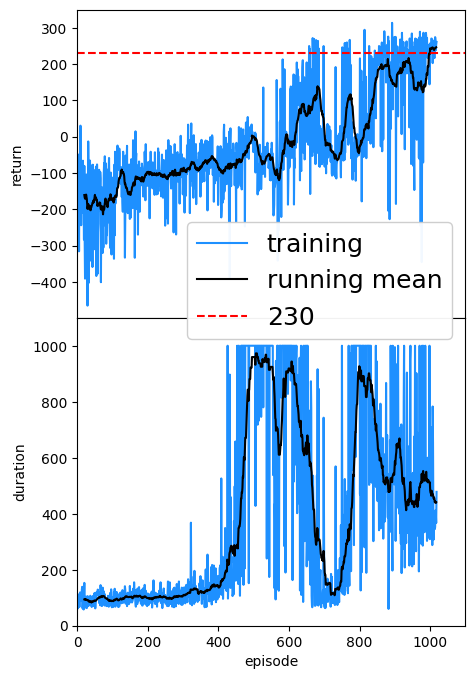

In [16]:
# Plot both the return per episode and the duration per episode during
# training, together with their running average over 20 consecutive episodes

N = 20 # number of episodes for running average

def running_mean(x,N=20):
        x_out = np.zeros(len(x)-N,dtype=float)
        for i in range(len(x)-N):
                x_out[i] = np.mean(x[i:i+N+1])
        return x_out

def plot_returns_and_durations(training_results,filename=None):
    fig,axes = plt.subplots(2,1,figsize=(5,8))
    fig.subplots_adjust(hspace=0.0001)
    #
    # return as a function of episode
    ax = axes[0]
    x = training_results['epsiode_returns']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(230,ls='--',
               label='230',
                        color='red')
    #
    ax.set_ylim(-499,350)
    ax.set_xticks([])
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'return')
    #
    #
    ax = axes[1]
    x = training_results['episode_durations']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(1200,ls='--', # draw line outside of plot scale,
                label='230', # to get the red dotted line into the legend
                        color='red')
    #
    ax.set_ylim(0,1100)
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'duration')
    ax.legend(loc='upper right',bbox_to_anchor=(1.,1.35),
                                framealpha=0.95,
                        fontsize=18)
    #
    plt.show()
    if filename != None:
        fig.savefig(filename,bbox_inches='tight')
    plt.close(fig)

plot_returns_and_durations(training_results=training_results)

# Create gameplay video using trained agent

First we create a "live" video that pops up and shows Lunar Lander gameplay performed by the agent

In [17]:
# There is the issue that the game window freezes when running gym games
# in jupyter notebooks, see https://github.com/openai/gym/issues/2433
# We here use the fix from that website, which is to use the following
# wrapper class:
class PyGameWrapper(gym.Wrapper):
    def render(self, **kwargs):
        retval = self.env.render( **kwargs)
        for event in pygame.event.get():
            pass
        return retval

In [18]:
# Create a wrapped environment
env = PyGameWrapper(gym.make('LunarLander-v2',render_mode='human'))

N_episodes = 20

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        #env.render()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break

env.close()

Run 1: duration = 294, total return = 269.554
Run 2: duration = 317, total return = 248.839
Run 3: duration = 309, total return = 222.451
Run 4: duration = 337, total return = 255.566
Run 5: duration = 256, total return = 263.438
Run 6: duration = 1000, total return =  71.284
Run 7: duration = 259, total return = 298.206
Run 8: duration = 293, total return = 234.357
Run 9: duration = 323, total return = 235.785
Run 10: duration = 297, total return = 249.251
Run 11: duration = 289, total return = 244.535
Run 12: duration = 267, total return = 263.708
Run 13: duration = 268, total return = 264.334
Run 14: duration = 330, total return = 203.603
Run 15: duration = 312, total return = 251.528
Run 16: duration = 295, total return = 234.502
Run 17: duration = 289, total return = 253.962
Run 18: duration = 348, total return = 227.560
Run 19: duration = 280, total return = 246.955
Run 20: duration = 319, total return = 263.642


We also create a video file containing 20 games played by the agent

In [19]:
from gymnasium.wrappers.monitoring import video_recorder

env = gym.make('LunarLander-v2', render_mode="rgb_array")
video = video_recorder.VideoRecorder(env, './video.mp4'.format())

N_episodes = 20

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        video.capture_frame()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break

video.close()
env.close()

Run 1: duration = 321, total return = 264.990
Run 2: duration = 282, total return = 245.347
Run 3: duration = 294, total return = 238.867
Run 4: duration = 275, total return = 274.033
Run 5: duration = 1000, total return =  89.041
Run 6: duration = 562, total return = 213.132
Run 7: duration = 318, total return = 250.383
Run 8: duration = 291, total return = 230.973
Run 9: duration = 301, total return = 287.233
Run 10: duration = 238, total return = 270.526
Run 11: duration = 533, total return = 218.591
Run 12: duration = 278, total return = 245.135
Run 13: duration = 369, total return = 263.340
Run 14: duration = 312, total return = 254.859
Run 15: duration = 304, total return = 237.179
Run 16: duration = 318, total return = 248.234
Run 17: duration = 634, total return = 221.564
Run 18: duration = 475, total return = 226.276
Run 19: duration = 299, total return = 248.521
Run 20: duration = 316, total return = 293.450
Moviepy - Building video ./video.mp4.
Moviepy - Writing video ./vide

Moviepy - Done !
Moviepy - video ready ./video.mp4
